# Project main drivers

### For this project three main questions must be answered:

* Where are located the markets in New York?

* What is the best neighborhood and/or borough in that a market will have better chances to thrive?

* What is the most strategic position for a delivery-focused market in relation to proximity to populated areas?

## 1. Importing libraries

* Let´s start importing all required Python libraries for this project

In [25]:
import pandas as pd
import numpy as np
import geocoder
import bs4
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

print("No errors found - Everything successfully loaded!")

No errors found - Everything successfully loaded!


## 2 - Scrapping neighborhood data from website (json file)

* The website returns a json file, which means a parsing with BeautifulSoup is not necessary, we can read it directly with the JSON package previously imported.



In [27]:
def new_york_address():
    resp=requests.get('https://cocl.us/new_york_dataset').json()
    features=resp['features']
    # defining the dataframe
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # filling the dataframe with spatial data from the json file
    new_york_address = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_address = new_york_address.append({'Borough': borough,'Neighborhood': neighborhood_name, 'Latitude': neighborhood_lat,'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_address

In [28]:
ny_data = new_york_address()
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_data['Borough'].unique()),
        ny_data.shape[0]
    )
)


The dataframe has 5 boroughs and 306 neighborhoods.


In [29]:
ny_data.head() #checking the newly created dataframe

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 3 - Putting on Foursquare credentials and fetching data through the API


In [30]:
CLIENT_ID = '0IR3SA2HSAXN2N2UHVALDTJK34ATHB3WJ3UHPJVOU1YTQOBJ'
# Foursquare Client ID
CLIENT_SECRET = 'KP2HTVCZRYDYB2XWILJ1U4SADJE2ZUZ4Y2GIJHUT4RTKUX0O' # Foursquare Client Secret
VERSION = '20180605'
LIMIT = 100

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: 0IR3SA2HSAXN2N2UHVALDTJK34ATHB3WJ3UHPJVOU1YTQOBJ
CLIENT_SECRET:KP2HTVCZRYDYB2XWILJ1U4SADJE2ZUZ4Y2GIJHUT4RTKUX0O


#### 3.1 - Fetching venue coordinates and id through Foursquare API calls

In [39]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [48]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [113]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Borough'], ny_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [83]:
def get_venues(lat,lng):
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

In [84]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [114]:
ny_data.shape

(306, 4)

## 4 Analyzing collected data 

* Now let's analyse how many markets and supermarkets exists in each neighborhood/ borough.

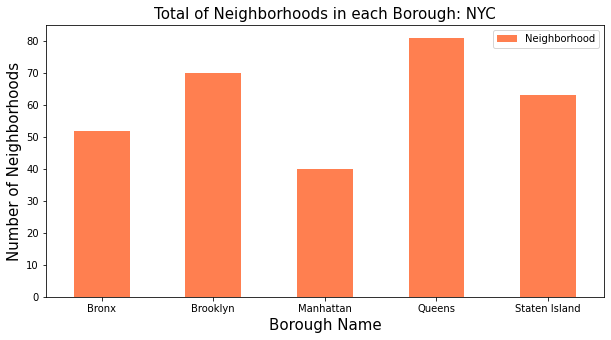

In [55]:
clr = "coral"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Total of Neighborhoods in each Borough: NYC', fontsize = 15)
plt.xlabel('Borough Name', fontsize = 15)
plt.ylabel('Number of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [121]:
# prepare neighborhood list that contains supermarkets
column_names=['Borough', 'Neighborhood', 'ID','Name']
spmarket_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    spmarket=venues[venues['Category']=='Supermarket']   
    print('(',count,'/',len(ny_data),')','Supermarket in '+Neighborhood+', '+Borough+':'+str(len(spmarket)))
    print(row)
    for resturant_detail in spmarket.values.tolist():
        id, name , category=resturant_detail
        spmarket_ny = spmarket_ny.append({'Borough': Borough,'Neighborhood': Neighborhood, 'ID': id,'Name' : name},ignore_index=True)
    count+=1

73.86704147658772]
( 143 / 306 ) Supermarket in Maspeth, Queens:0
['Queens', 'Maspeth', 40.725427374093606, -73.89621713626859]
( 144 / 306 ) Supermarket in Ridgewood, Queens:0
['Queens', 'Ridgewood', 40.70832315613858, -73.90143517559589]
( 145 / 306 ) Supermarket in Glendale, Queens:0
['Queens', 'Glendale', 40.70276242967838, -73.87074167435605]
( 146 / 306 ) Supermarket in Rego Park, Queens:0
['Queens', 'Rego Park', 40.72897409480735, -73.8578268690537]
( 147 / 306 ) Supermarket in Woodhaven, Queens:0
['Queens', 'Woodhaven', 40.68988687915789, -73.8581104655432]
( 148 / 306 ) Supermarket in Ozone Park, Queens:1
['Queens', 'Ozone Park', 40.680708468265415, -73.84320266173447]
( 149 / 306 ) Supermarket in South Ozone Park, Queens:1
['Queens', 'South Ozone Park', 40.66854957767195, -73.80986478649041]
( 150 / 306 ) Supermarket in College Point, Queens:0
['Queens', 'College Point', 40.784902749260205, -73.84304528896125]
( 151 / 306 ) Supermarket in Whitestone, Queens:1
['Queens', 'Whit

In [122]:
spmarket_ny.to_csv('spmarket_ny.csv')

In [56]:
spmarket_ny = pd.read_csv('spmarket_ny.csv')
spmarket_ny.head()

,Unnamed: 0,Unnamed: 0.1,Borough,Neighborhood,ID,Name
0,0,0,Bronx,Norwood,564f83d4498ee9597ad80f23,Stop & Shop
1,1,1,Bronx,Pelham Parkway,564f83d4498ee9597ad80f23,Stop & Shop
2,2,2,Bronx,City Island,564f83d4498ee9597ad80f23,Stop & Shop
3,3,3,Bronx,Morris Heights,49f85cbbf964a520f26c1fe3,Mitsuwa Marketplace
4,4,4,Bronx,High Bridge,49f85cbbf964a520f26c1fe3,Mitsuwa Marketplace


In [57]:
spmarket_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    78 non-null     int64 
 1   Unnamed: 0.1  78 non-null     int64 
 2   Borough       78 non-null     object
 3   Neighborhood  78 non-null     object
 4   ID            78 non-null     object
 5   Name          78 non-null     object
dtypes: int64(2), object(4)
memory usage: 3.8+ KB


### The call returned 78 different supermarkets in New York. The collected data was saved in a .csv file.
### Now to continue the analysis, let's segment this search querry by Neighborhood, in order to retrieve which Neighborhood has the biggest number of supermarkets

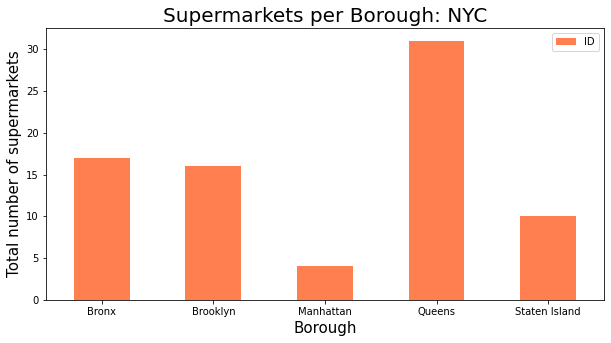

In [76]:
spmarket_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Supermarkets per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total number of supermarkets', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

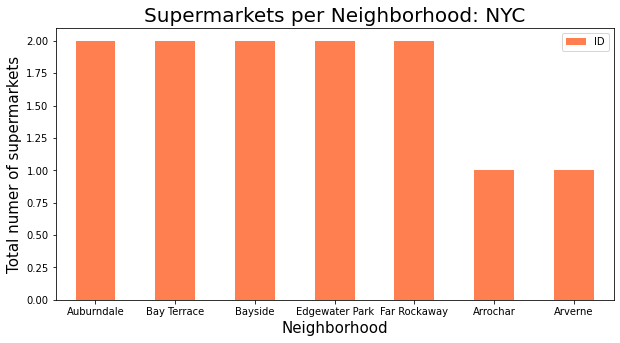

In [58]:
spmarket_ny.groupby('Neighborhood')['ID'].count().nlargest(7).plot.bar(figsize=(10,5), color=clr)
plt.title('Supermarkets per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Total number of supermarkets', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [245]:
spmarket_ny[spmarket_ny['Neighborhood']=='Auburndale']

,Unnamed: 0,Unnamed: 0.1,Borough,Neighborhood,ID,Name
38,38,38,Queens,Auburndale,563c11e8cd1059cb26ede621,Stop & Shop
39,39,39,Queens,Auburndale,4ac8fe84f964a520d7bd20e3,H Mart


* Auburndale, Bay Terrace, Bayside, Edgewater Park and Farrockaway are the neighborhoods with the highest number of supermarkets.

* Queens is the area with the most number of supermarkets

In [62]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [63]:
#Creating Dataframe ny_vanues
ny_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [64]:
ny_venues.to_csv('ny_venues.csv') #saving to a .csv file so we don't need to call the API again

In [65]:
#Checking the size of the resulting dataframe
print(ny_venues.shape)
ny_venues.head()

(10097, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [66]:
# checking how many venues were returned for each neighborhood
ny_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,29,29,29,29,29,29
Annadale,10,10,10,10,10,10
Arden Heights,4,4,4,4,4,4
Arlington,5,5,5,5,5,5
Arrochar,23,23,23,23,23,23
...,...,...,...,...,...,...
Woodhaven,23,23,23,23,23,23
Woodlawn,26,26,26,26,26,26
Woodrow,16,16,16,16,16,16


In [67]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 432 uniques categories.


#### 5.1 Analysing Each Neighborhood

In [116]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
ny_onehot.shape

(10097, 432)

#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [118]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,Woodhaven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
297,Woodlawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
298,Woodrow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
299,Woodside,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037975,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.012658,0.0,0.0,0.0


In [119]:
ny_grouped.shape

(301, 432)

#### Let's print each neighborhood along with the number of supermarkets

In [120]:
num_top_venues = 5

for hood in ny_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

            Deli / Bodega  0.17
1                         Bus Stop  0.07
2  Southern / Soul Food Restaurant  0.07
3                      Supermarket  0.07
4              Fried Chicken Joint  0.07


----Ocean Parkway----
                   venue  freq
0            Supermarket  0.06
1             Playground  0.06
2  General Entertainment  0.06
3              Gift Shop  0.06
4       Sushi Restaurant  0.06


----Old Town----
                venue  freq
0  Italian Restaurant  0.22
1          Restaurant  0.06
2        Liquor Store  0.06
3        Optical Shop  0.06
4       Grocery Store  0.06


----Olinville----
                  venue  freq
0  Caribbean Restaurant  0.22
1          Liquor Store  0.22
2           Supermarket  0.11
3                  Food  0.11
4         Deli / Bodega  0.11


----Ozone Park----
         venue  freq
0     Pharmacy  0.08
1  Pizza Place  0.08
2         Bank  0.06
3        Diner  0.06
4          Gym  0.06


----Paerdegat Basin----
              venue  freq
0       

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [122]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_venues_sorted = pd.DataFrame(columns=columns)
ny_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Cosmetics Shop,Supermarket,Gas Station,Grocery Store,Breakfast Spot,Spa,Check Cashing Service,Intersection
1,Annadale,Restaurant,Pub,Pharmacy,Bakery,Train Station,Pizza Place,Food,Park,Deli / Bodega,Diner
2,Arden Heights,Deli / Bodega,Pizza Place,Coffee Shop,Pharmacy,Pie Shop,Physical Therapist,Photography Studio,Pet Store,Pet Service,Pet Café
3,Arlington,Deli / Bodega,Bus Stop,Intersection,American Restaurant,Boat or Ferry,Outdoor Sculpture,Outdoor Gym,Physical Therapist,Photography Studio,Pharmacy
4,Arrochar,Pizza Place,Bus Stop,Deli / Bodega,Italian Restaurant,Bagel Shop,Sandwich Place,Outdoors & Recreation,Taco Place,Food Truck,Nail Salon


### 5 - Creating clusters for each neighborhood

In [123]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 1, 0, 3, 3, 3, 3, 0])

In [124]:
# Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
ny_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_data

# merge ny_grouped with ny_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(ny_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0.0,Pharmacy,Deli / Bodega,Laundromat,Caribbean Restaurant,Ice Cream Shop,Donut Shop,Sandwich Place,Dessert Shop,Outdoors & Recreation,Outdoor Gym
1,Bronx,Co-op City,40.874294,-73.829939,0.0,Bus Station,Park,Bagel Shop,Post Office,Fast Food Restaurant,Salon / Barbershop,Grocery Store,Pizza Place,Donut Shop,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,0.0,Bus Station,Caribbean Restaurant,Diner,Deli / Bodega,Bakery,Seafood Restaurant,Metro Station,Convenience Store,Chinese Restaurant,Cosmetics Shop
3,Bronx,Fieldston,40.895437,-73.905643,3.0,River,Medical Supply Store,Bus Station,Plaza,Yoga Studio,Pedestrian Plaza,Photography Studio,Pharmacy,Pet Store,Pet Service
4,Bronx,Riverdale,40.890834,-73.912585,3.0,Park,Baseball Field,Gym,Playground,Food Truck,Gym / Fitness Center,Plaza,Home Service,Bus Station,Bank


#### 5.1 Plot map with clusters

In [125]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


TypeError: list indices must be integers or slices, not float